XGBoost (No Weighting) — Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1388
           1       1.00      1.00      1.00        73

    accuracy                           1.00      1461
   macro avg       1.00      1.00      1.00      1461
weighted avg       1.00      1.00      1.00      1461



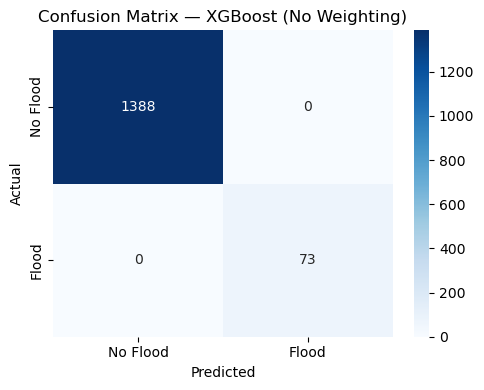

ROC-AUC (XGB no weight): 1.000


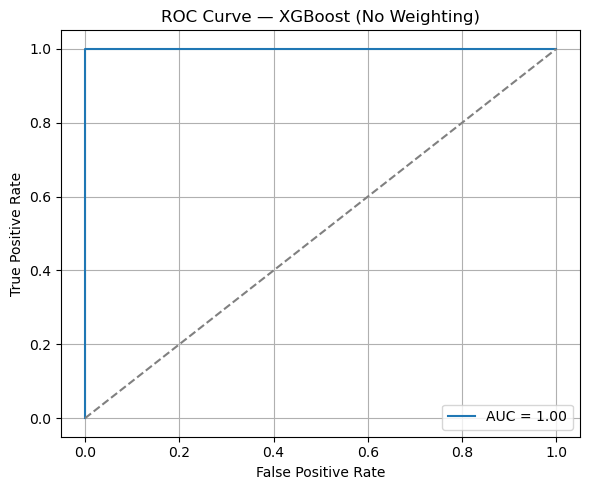

CV F1 scores (XGB no weight): [1.         0.95364238 1.         0.96551724 0.99319728]
Mean F1 (XGB no weight): 0.9824713808793671


In [1]:
# models/xgboost_flood_no_weight.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from xgboost import XGBClassifier

#data loading
df = pd.read_csv("flood_model_lagged.csv", parse_dates=["date"])
X = df.drop(columns=["date", "flood"])
y = df["flood"].astype(int)

#train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

#model training
xgb = XGBClassifier(
    random_state=42,
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    
)
xgb.fit(X_train, y_train)


y_pred  = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]


print("XGBoost (No Weighting) — Classification Report")
print(classification_report(y_test, y_pred, digits=2))


plt.figure(figsize=(5, 4))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True, fmt="d", cmap="Blues",
    xticklabels=["No Flood", "Flood"],
    yticklabels=["No Flood", "Flood"]
)
plt.title("Confusion Matrix — XGBoost (No Weighting)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC-AUC (XGB no weight): {roc_auc:.3f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost (No Weighting)")
plt.legend(loc="lower right"); plt.grid(True)
plt.tight_layout(); plt.show()

cv_scores = cross_val_score(xgb, X, y, cv=5, scoring="f1")
print("CV F1 scores (XGB no weight):", cv_scores)
print("Mean F1 (XGB no weight):", cv_scores.mean())


#dump(xgb, "xgb_flood_model_no_weight.pkl")
#print("✅ Saved: xgb_flood_model_no_weight.pkl")



In [3]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("flood_model_lagged.csv", parse_dates=["date"])
df = df.sort_values("date")

X = df.drop(columns=["date","flood"])
y = df["flood"].astype(int)

# ----Tsplit by time  where train <= 2018-12-31, test >= 2019-01-01
train_mask = df["date"] < "2019-01-01"
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

xgb = XGBClassifier(
    random_state=42, n_estimators=400, max_depth=4, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    objective="binary:logistic", eval_metric="logloss", n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       0.98      0.98      0.98        51

    accuracy                           1.00      1096
   macro avg       0.99      0.99      0.99      1096
weighted avg       1.00      1.00      1.00      1096

